## Step 2. EDA train chunks

-----
### read DF

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data_path = "/workspace/dataset/"

In [3]:
df = pd.read_csv(data_path + "train_sample.csv")
print(df.shape)
df.head()

(8134818, 11)


,bcateid,brand,dcateid,maker,mcateid,model,pid,price,product,scateid,updttm
0,1,퍼즐라이프,-1,상품상세설명 참조,1,퍼즐라이프 직소퍼즐 바다거북의 여행,b'O4486751463',16520,직소퍼즐 - 1000조각 바다거북의 여행 (PL1275),2,b'20180227091029'
1,3,바보사랑,-1,MORY|해당없음,3,아이폰6S/6S+ tree farm101 - 다이어리케이스|아이폰6S/6S+,b'P3307178849',20370,[모리케이스]아이폰6S/6S+ tree farm101 - 다이어리케이스[바보사랑][...,4,b'20180429085019'
2,5,크리비아,-1,NaN,5,크리비아 기모 3부 속바지 GLG4314P,b'R4424255515',-1,크리비아 기모 3부 속바지 GLG4314P,6,b'20180426102314'
3,7,잭앤질,-1,㈜크리스패션,7,[잭앤질] 남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,b'F3334315393',16280,[하프클럽/잭앤질]남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,8,b'20180422084512'
4,10,NaN,-1,기타,9,SD코드프리혈당시험지[50매],b'N731678492',-1,코드프리혈당시험지50매/코드프리시험지/최장유효기간,11,b'20180424071623'


In [4]:
df.columns

Index(['bcateid', 'brand', 'dcateid', 'maker', 'mcateid', 'model', 'pid',
       'price', 'product', 'scateid', 'updttm'],
      dtype='object')

### show y(cate) distribution

In [4]:
def show_dist_col(df, col_name, remove_empty=True):
    ax = 0
    if remove_empty:
        ax = df[col_name].value_counts()[1:]
    else:
        ax = df[col_name].value_counts()
    print("unique length :", str(len(ax)))

    plt.bar(np.arange(len(ax.index)), ax.values)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)

unique length : 57


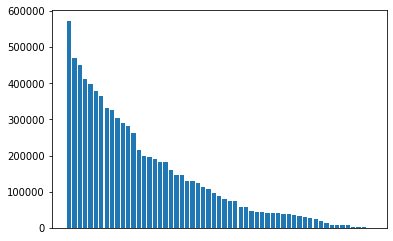

In [47]:
show_dist_col(df, "bcateid", remove_empty=False)

unique length : 552


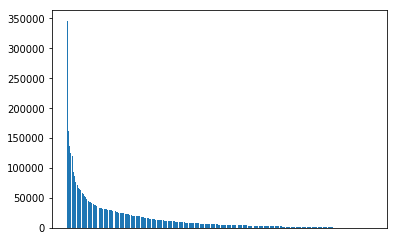

In [48]:
show_dist_col(df, "mcateid", remove_empty=False)

unique length : 3189


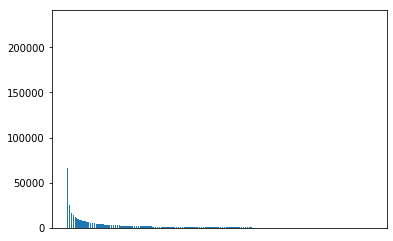

In [49]:
show_dist_col(df, "scateid", remove_empty=True)

unique length : 403


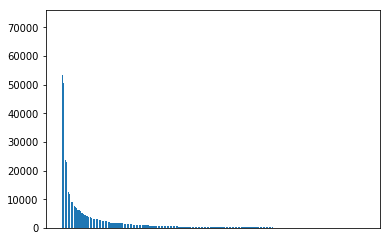

In [50]:
show_dist_col(df, "dcateid", remove_empty=True)

### small, detail cate empty check

In [35]:
s_empty_ratio = df.scateid.value_counts().tolist()[0] / sum(df.scateid.value_counts())
print("small cate's empty ratio :", str(round(s_empty_ratio, 2)))

small cate's empty ratio : 0.23


In [36]:
d_empty_ratio = df.dcateid.value_counts().tolist()[0] / sum(df.dcateid.value_counts())
print("detail cate's empty ratio :", str(round(d_empty_ratio, 2)))

detail cate's empty ratio : 0.91


### make cid (comb all cate)

In [59]:
def concat_cate(b, m, s, d):
    cid = [str(b), str(m), str(s), str(d)]
    return("_".join(cid))

In [60]:
df['cid'] = df.apply(lambda x: concat_cate(x['bcateid'], x['mcateid'], x['scateid'], x['dcateid']), axis=1)

In [64]:
df['cid'].value_counts()[:10]

24_31_34_5       72344
50_201_-1_-1     66904
6_14_149_-1      66451
3_3_38_10        60313
3_3_38_-1        55871
20_132_195_-1    53778
3_3_38_8         53278
3_3_38_6         50747
3_3_375_-1       47568
17_20_53_-1      47516
Name: cid, dtype: int64

In [62]:
len(df['cid'].value_counts())

4215

unique length : 4215


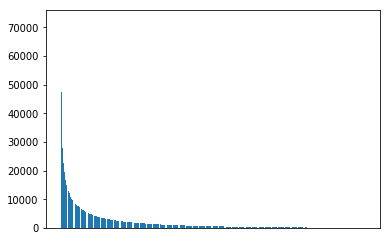

In [63]:
show_dist_col(df, "cid", remove_empty=False)

# Question :  RNN 방식으로 4개의 cell을 예측하면 57, 552, 3190, 404 개의 one-hot을 예측하는 것?
- 만약 그렇다면 조합의 개수 4215개로 하는게 낫지 않나??
- 조합을 한다는 것은 나름의 ruleset을 가지고 structure 구조가 된다는 것인데, 구조가 없는 57 X 552 X 3190 X 404 보다 낫지 않을까??

- cate 조합을 y로 쓰는 것(4215)의 문제점 : 새로운 조합에 대해서는 예측이 불가능?
- cate 조합을 y로 쓰는 것(4215)의 장점 : 이미 어느정도 만들어놓은 association ruleset과 비슷한 효과를 가질 듯?
- RNN 연속성 예측의 문제점 : 학습 연산량이 지나치게 많을 듯?
- RNN 연속성 예측의 장점 : 학습만 제대로 된다면 새로운 조합에 대해서 예측이 가능, 그리고 아마도 더 정확할 듯?
###### RNN 연속성 예측 질문 : cell마다 다른 one-hot size의 output으로 나가는게 가능한가?

- 의견 1 : 아마 Test 데이터 셋에서 새로운 카테고리 조합이 많이 나올 것 같지는 않음.
- 의견 2 : 아마 RNN이 더 정확할 것 같음.
- 그러니 두 방법 모두 다 테스트 해서 성능을 비교해봐야 할 듯.

-----
-----
### EDA x-features

#### check train pid in dev
- insight : dev의 pid는 train에서 한번도 등장하지 않았던 item

In [6]:
df.pid.value_counts()[:10]

b'N4494825834'    1
b'M1436321812'    1
b'S4569373738'    1
b'I4435633408'    1
b'Q1436470624'    1
b'P3903145886'    1
b'K4621158488'    1
b'T4636452079'    1
b'L3054860426'    1
b'X3885512402'    1
Name: pid, dtype: int64

In [4]:
dev_df = pd.read_csv(data_path + "dev_sample.csv")

In [14]:
df.pid.value_counts()[:10]

b'N4494825834'    1
b'M1436321812'    1
b'S4569373738'    1
b'I4435633408'    1
b'Q1436470624'    1
b'P3903145886'    1
b'K4621158488'    1
b'T4636452079'    1
b'L3054860426'    1
b'X3885512402'    1
Name: pid, dtype: int64

In [8]:
train_pid_dict = dict(df.pid.value_counts())

In [24]:
def check_pid_dict(pid):
    if pid in train_pid_dict:
        return 1
    else:
        return 0

dev_df['used_pid'] = dev_df.pid.apply(lambda x: check_pid_dict(x))

In [25]:
dev_df['used_pid'].value_counts() ## --> dev의 pid는 train에서 한번도 등장하지 않았던 item

0    507783
Name: used_pid, dtype: int64

-----
-----
#### brand eda
- insight : 약 4%정도가 브랜드 쓰레기값 포함
- 약 50%정도가 브랜드 결측

In [5]:
len(df.brand.value_counts()) ## --> 브랜드 종류 약 19만개

193459

In [5]:
brand_list = df.brand.value_counts().index.tolist()

In [6]:
exception_dict = ["참조", "없음", "표기", "별도", "상세", "자체"]
exception_list = []

In [7]:
for brand in brand_list:
    if any(word in brand for word in exception_dict):
        exception_list.append(brand)

In [9]:
df[df['brand'].isin(exception_list)]['brand'].shape[0] / df.shape[0] ## --> 약 4%정도가 브랜드 쓰레기값 포함

0.04116588717780779

In [10]:
df.brand.isnull().sum() / df.shape[0] ## --> 약 50%정도가 브랜드 결측

0.48312340853845775

In [11]:
df.isnull().sum()

bcateid          0
brand      3930121
dcateid          0
maker      2196847
mcateid          0
model      2063426
pid              0
price            0
product          0
scateid          0
updttm           0
dtype: int64

In [12]:
no_trash_brand_list = df[~df['brand'].isin(exception_list)]['brand'].value_counts()

In [16]:
no_trash_brand_list = no_trash_brand_list[no_trash_brand_list > 100]

In [17]:
len(no_trash_brand_list)

5042

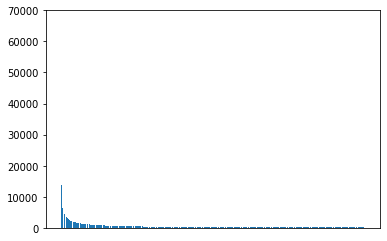

In [18]:
plt.bar(np.arange(len(no_trash_brand_list.index)), no_trash_brand_list.values)
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)

In [27]:
no_trash_brand_list[:10]

바보사랑     66645
기타       64144
아디다스     32292
나이키      30785
아트박스     28518
1300K    20791
텐바이텐     15397
핫트랙스     14835
삼성전자     14770
오가닉맘     14694
Name: brand, dtype: int64

In [26]:
df[df['brand'] == "바보사랑"]['bcateid'].value_counts()[:10]

3     17821
11    13502
35     6519
16     4591
14     4351
8      2492
50     2188
20     1764
1      1434
49     1320
Name: bcateid, dtype: int64

- counts 상위 브랜드 : 대부분의 bcateid를 포함.
- counts 하위 브랜드 : 갯수가 너무 많음

#### check train brand in dev
- insight : dev의 brand는 train에서 3%정도는 등장하지 않았던 브랜드

In [8]:
train_brand_dict = dict(df.brand.value_counts())

In [9]:
def check_brd_dict(pid):
    if pid in train_brand_dict:
        return 1
    else:
        return 0

test = dev_df.dropna(subset=['brand']).brand.apply(lambda x: check_brd_dict(x))

In [10]:
test.value_counts() ## --> dev의 brand는 train에서 3%정도는 등장하지 않았던 브랜드

1    252278
0      9771
Name: brand, dtype: int64

In [11]:
9771 / 252278

0.03873108237737734

#### brand normalized distribution

In [22]:
no_trash_brand_list = df[~df['brand'].isin(exception_list)]['brand'].value_counts()

In [23]:
from scipy import stats

In [24]:
brand_z_list = stats.zscore(no_trash_brand_list.values)
print(brand_z_list.min())
print(brand_z_list.max())
print(len(brand_z_list))

-0.06294202190025026
220.3748984343736
193211


In [28]:
datamin = -5
datamax = 5
numbins = 1000
mybins = np.linspace(datamin, datamax, numbins)

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

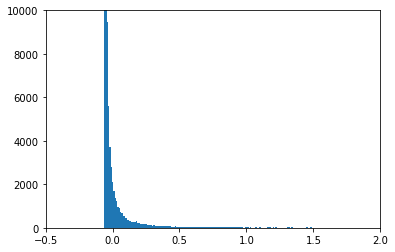

In [36]:
plt.ylim(0, 10000)
plt.xlim(-0.5, 2)
plt.hist(brand_z_list, bins=mybins)

In [35]:
len(brand_z_list[np.where((-0.001 < brand_z_list) & (brand_z_list < 0.5))])

16273

# 브랜드 EDA 정리
- 결측값, 쓰레기값이 아닌 절반 정도의 브랜드 대상 (약 19만)
- 1차 필터링 : dev, test 데이터에 등장하는 브랜드
- 2차 필터링 : brand item cnt z-score -0.001 ~ 0.5 사이 -> 대부분의 일반 면적 커버
- insight : brand의 item cnt가 매우 높은 경우는 대부분의 카테고리에 해당하기 때문에 변별력 부족, 반대의 경우 데이터 부족
- 1~2차 필터링된 브랜드 외 -> 'another brand'로 정의

-----
-----
-----
-----
-----
-----
-----
-----
-----
-----
-----


In [ ]:
todo

In [39]:
['maker', 'price', 'updttm']

['maker', 'price', 'updttm']

In [48]:
## 브랜드 정보는 없지만 제조사 정보만 있는 경우 : 약 30%
len(df[(df.maker.notnull()) & (df.brand.isnull())][['maker']]) / df.shape[0]

0.27929893453055743

In [55]:
maker_list = df.maker.value_counts().index.tolist()

exception_dict = ["참조", "없음", "표기", "별도", "상세", "자체", "불명", "미입력"]
exception_list = []

for maker in maker_list:
    if any(word in maker for word in exception_dict):
        exception_list.append(maker)

In [57]:
df[(df.maker.notnull()) & (df.brand.isnull()) & ~df['maker'].isin(exception_list)]['maker'].value_counts()

# 제조사 EDA 정리 (작업중)
- 1차 필터링 : 결측값, 쓰레기값이 아닌 메이커 대상
- 2차 필터링 : 브랜드 없이 제조사만 등장하는 데이터에 등장하는 제조사 :: -> 대부분은 브랜드가 상품력이 훨씬 높기 때문에, 브랜드를 포함하지 않은 데이터에서 상품력을 얼마나 발휘하는지의 여부를 측정. 브랜드와 동시 등장하는 제조사는 상품력이 매우 낮을 것으로 판단됨(가설)
- 3차 필터링 : z-score (작업중)